In [150]:
from joblib import dump, load
import json
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import nltk
from nltk import word_tokenize
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Import csv data
df_us = pd.read_csv("../data/USvideos.csv")
df_ca = pd.read_csv("../data/CAvideos.csv")
df_gb = pd.read_csv("../data/GBvideos.csv")

In [3]:
df_us.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [4]:
# Extract the category ids used in csv files from json files
def extract_cat_id(file_path):
    # Load json file
    with open(file_path) as js:
        d = json.load(js)
    # Normalize nested dict, and drop irrelevant cols
    df = json_normalize(d['items'])
    df_items = df.drop(columns=['kind', 'etag', 'snippet.channelId', 'snippet.assignable'])
    return df_items

In [5]:
us_cats = extract_cat_id('../data/US_category_id.json')
ca_cats = extract_cat_id('../data/CA_category_id.json')
gb_cats = extract_cat_id('../data/GB_category_id.json')
us_cats.head()

,id,snippet.title
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music
3,15,Pets & Animals
4,17,Sports


# Category Information

In [6]:
# Create dictionary for cat number to name
def generate_cat_dict(country_cats):
    cat_id_list = country_cats["id"]
    cat_name_list = country_cats["snippet.title"]
    cat_dict = {cat_id_list[i]: cat_name_list[i] for i in range(len(cat_id_list))}
    return cat_dict

In [7]:
us_cat_dict = generate_cat_dict(us_cats)
ca_cat_dict = generate_cat_dict(us_cats)
gb_cat_dict = generate_cat_dict(us_cats)
us_cat_dict

{'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '29': 'Nonprofits & Activism',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

In [8]:
# Print the total number of trending categories for specified country
def cat_count(df, country_name):
    print(country_name + ": " + str(len(df)) + " trending categories")

In [9]:
cat_count(us_cats, "United States")

United States: 32 trending categories


In [10]:
cat_count(ca_cats, "Canada")

Canada: 31 trending categories


In [11]:
cat_count(gb_cats, "Great Britain")

Great Britain: 31 trending categories


### Insight from above: All three countries have about the same number of total trending categories, with the US having one more than Canada and Great Britain.

In [12]:
# Generate which categories are trending in one country but not the other; indicate trending country
def trending_cat_diff(df_country1, df_country2):
    diff = df_country1.merge(df_country2, how='outer', indicator=True).loc[lambda x : x['_merge'] != 'both']
    return diff

In [13]:
trending_cat_diff(us_cats, gb_cats)

,id,snippet.title,_merge
16,29,Nonprofits & Activism,left_only


In [14]:
# Check previous diff func
def trending_cat_diff2(df_country1, df_country2):
    diff = pd.concat([df_country1,df_country2]).drop_duplicates(keep=False)
    return diff

In [15]:
trending_cat_diff2(us_cats, gb_cats)

,id,snippet.title
16,29,Nonprofits & Activism


In [16]:
trending_cat_diff(us_cats, ca_cats)

,id,snippet.title,_merge
16,29,Nonprofits & Activism,left_only


In [17]:
trending_cat_diff(gb_cats, ca_cats)

,id,snippet.title,_merge


### Insight from above: Nonprofits & Activism is a trending category in the US but not Canada and Great Britain. Futher, Candada and Great Britain have the same trending categories.

In [18]:
# Create cat_name feature using cat_dict
def generate_cat_name_feature(df, country_cat_dict):
    cat_id_str = df["category_id"].apply(lambda x: str(x))
    df["category_name"] = cat_id_str.map(country_cat_dict)
    return df

In [19]:
generate_cat_name_feature(df_us, us_cat_dict)
generate_cat_name_feature(df_ca, ca_cat_dict)
generate_cat_name_feature(df_gb, gb_cat_dict)
generate_cat_name_feature(df_us, us_cat_dict).head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment


In [20]:
# Add the number of times each category has been the category of a trending video
def sum_cat_trend(df, country_cats):
    data = pd.DataFrame(columns=['category_name', 'count'])
    for i in range(len(country_cats)):
        cat_nm = country_cats["snippet.title"][i]
        tbl = df.loc[df_us["category_name"] == country_cats["snippet.title"][i], "category_name"]
        length = len(tbl)
        if(length == 0):
            continue
        data = data.append({'category_name' : cat_nm, 'count' : length}, ignore_index=True)
    data = data.sort_values(by='count', ascending=False)
    return data

In [21]:
ca_cat_trend_count = sum_cat_trend(df_ca, ca_cats)
gb_cat_trend_count = sum_cat_trend(df_gb, gb_cats)
us_cat_trend_count = sum_cat_trend(df_us, us_cats)
us_cat_trend_count

,category_name,count
9,Entertainment,9964
2,Music,6472
11,Howto & Style,4146
8,Comedy,3457
15,Comedy,3457
7,People & Blogs,3210
10,News & Politics,2487
13,Science & Technology,2401
0,Film & Animation,2345
4,Sports,2174


In [22]:
ca_cat_trend_count

,category_name,count
9,Entertainment,9950
2,Music,6452
11,Howto & Style,4141
8,Comedy,3450
14,Comedy,3450
7,People & Blogs,3204
10,News & Politics,2487
13,Science & Technology,2400
0,Film & Animation,2341
4,Sports,2173


In [23]:
gb_cat_trend_count

,category_name,count
9,Entertainment,9459
2,Music,5955
11,Howto & Style,3965
8,Comedy,3293
14,Comedy,3293
7,People & Blogs,3093
10,News & Politics,2451
13,Science & Technology,2320
0,Film & Animation,2187
4,Sports,2117


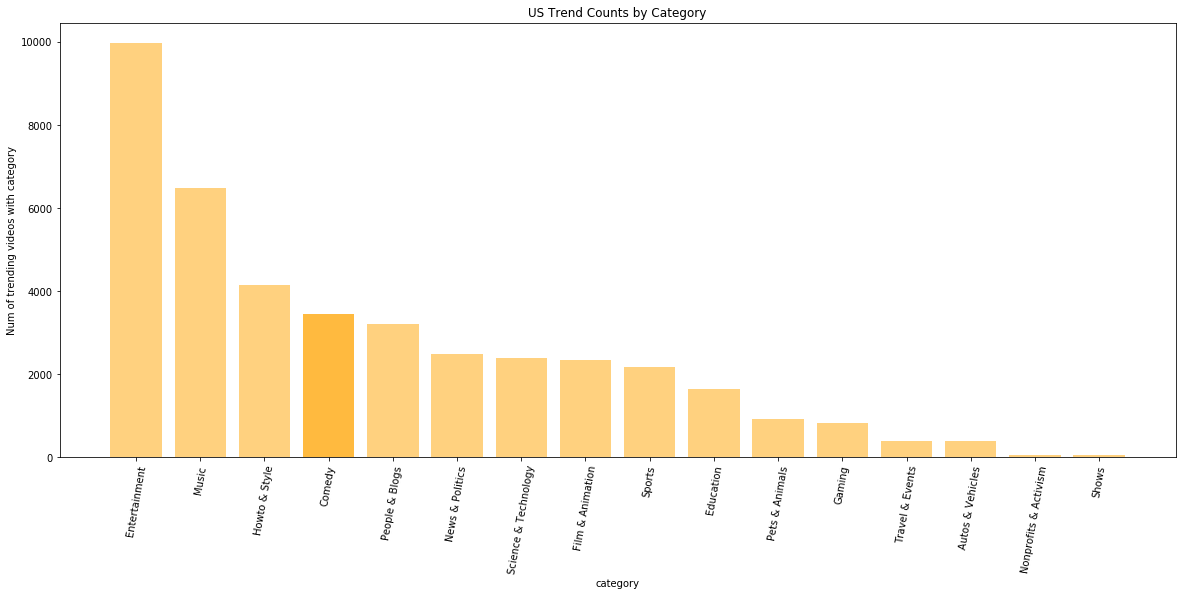

In [24]:
plt.figure(figsize=(20,8))
plt.bar(us_cat_trend_count['category_name'], us_cat_trend_count['count'], color='orange', alpha=0.5)
plt.xticks(rotation=80)
plt.title("US Trend Counts by Category")
plt.ylabel('Num of trending videos with category')
plt.xlabel('category');

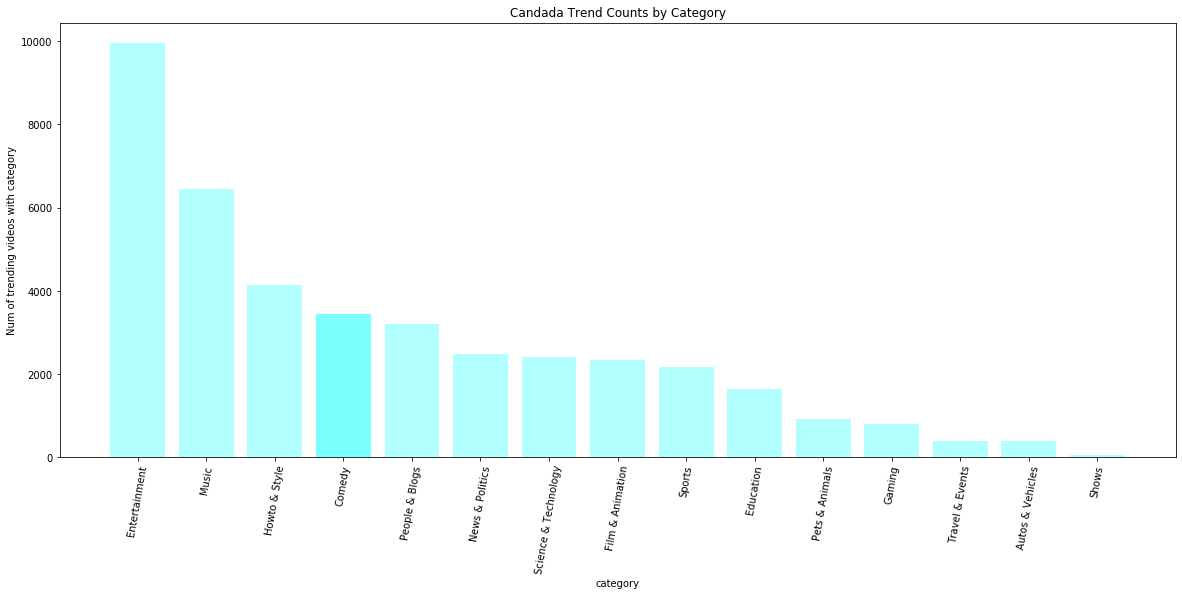

In [25]:
plt.figure(figsize=(20,8))
plt.bar(ca_cat_trend_count['category_name'], ca_cat_trend_count['count'], color='cyan', alpha=0.3)
plt.xticks(rotation=80)
plt.title("Candada Trend Counts by Category")
plt.ylabel('Num of trending videos with category')
plt.xlabel('category');

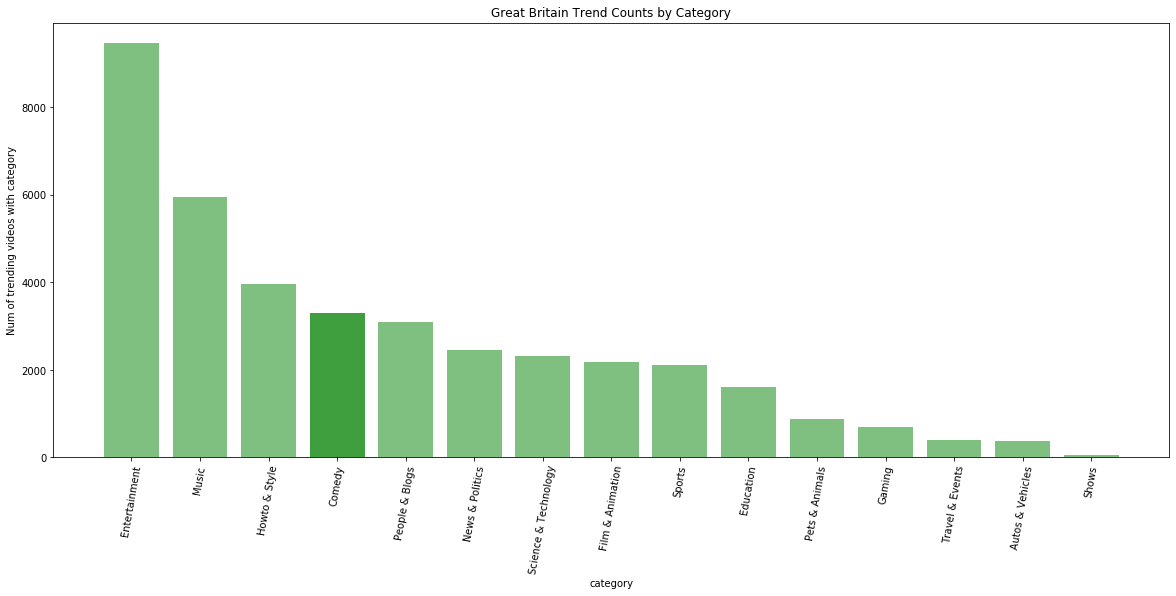

In [26]:
plt.figure(figsize=(20,8))
plt.bar(gb_cat_trend_count['category_name'], gb_cat_trend_count['count'], color='g', alpha=0.5)
plt.xticks(rotation=80)
plt.title("Great Britain Trend Counts by Category")
plt.ylabel('Num of trending videos with category')
plt.xlabel('category');

### Insight from above: It's interesting that the category rank (according to number of times it was the category of a trending video) is the same for all three countries. The only difference is that the US has an additional trending category (Nonprofits & Activism). While the rank order is interesting, it is uncanny how close the actual numbers are for each category - a quick scroll would lead one to believe the graphs are all the same. One note is that this is based on cumulative counts; trends for each category over time is in the section that shows trends over time.

# Engagement
Based on comments, likes/dislikes, and category

In [27]:
# Function to create engagement columns in given df
def create_engagement_features(df):
    df["comment_engagement"] = round(((df["comment_count"] / df["views"]) * 100), 2)
    df["like_dislike_engagement"] = round((((df["likes"] + df["dislikes"]) / df["views"]) * 100), 2)
    return df_us

In [28]:
create_engagement_features(df_us)
create_engagement_features(df_ca)
create_engagement_features(df_gb)
create_engagement_features(df_us).head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,comment_engagement,like_dislike_engagement
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,2.13,8.08
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment,0.53,4.27
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy,0.26,4.74
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment,0.63,3.16
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment,0.84,6.40


In [29]:
# Return count and percent of trending videos with like/dislike engagement above a given threshold percentage 
# (ex: enter 10 for 10% threshold)
def calc_like_dislike_engagement(df, threshold):
    like_dislike_engagement = df["like_dislike_engagement"].index[df["like_dislike_engagement"] > threshold]
    engagement_count = len(like_dislike_engagement)
    engagement_percentage = (engagement_count / len(df)) * 100
    return engagement_count, engagement_percentage

In [30]:
calc_like_dislike_engagement(df_us, 10)

(1218, 2.9744316100515276)

In [31]:
# Return count and percent of trending videos with comment engagement above a given threshold
# (ex: enter 10 for 10% threshold)
def calc_comment_engagement(df, threshold):
    comment_engagement = df["comment_engagement"].index[df["comment_engagement"] > threshold]
    engagement_count = len(comment_engagement)
    engagement_percentage = (engagement_count / len(df)) * 100
    return engagement_count, engagement_percentage

In [32]:
calc_comment_engagement(df_us, 2)

(835, 2.039121834477032)

### Insight from above: Only 2.9 % of trending videos have a like/dislike engagement (percentage of viewers who liked or disliked the video) over 10%. And only 2% of trending videos have a comment engagement (percentage of viewers who commented on the video) over 2%. So the claim that trending videos are based on more than just view count is interesting.

In [33]:
# Calculate comment engagement by category for given country
def calc_comment_engagement_cats(df):
    comment_engagement_by_cat = df.pivot_table('comment_engagement', index='category_name', aggfunc='mean')
    comment_engagement_by_cat = comment_engagement_by_cat.sort_values(by='comment_engagement', ascending=False)
    return comment_engagement_by_cat

In [34]:
us_comment_engagement_by_cat = calc_comment_engagement_cats(df_us)
ca_comment_engagement_by_cat = calc_comment_engagement_cats(df_ca)
gb_comment_engagement_by_cat = calc_comment_engagement_cats(df_gb)
us_comment_engagement_by_cat

,comment_engagement
category_name,
Gaming,0.746059
Nonprofits & Activism,0.730702
News & Politics,0.641705
Howto & Style,0.589016
Comedy,0.521869
People & Blogs,0.481903
Education,0.450628
Science & Technology,0.413499
Pets & Animals,0.401511


In [35]:
# Calculate like/dislike engagement by category for given country
def cal_like_dislike_engagement(df):
    like_dislike_engagement_by_cat = df.pivot_table('like_dislike_engagement', index='category_name', aggfunc='mean')
    like_dislike_engagement_by_cat = like_dislike_engagement_by_cat.sort_values(by='like_dislike_engagement', ascending=False)
    return like_dislike_engagement_by_cat

In [36]:
us_like_dislike_engagement_by_cat = cal_like_dislike_engagement(df_us)
ca_like_dislike_engagement_by_cat = cal_like_dislike_engagement(df_ca)
gb_like_dislike_engagement_by_cat = cal_like_dislike_engagement(df_gb)
us_like_dislike_engagement_by_cat

,like_dislike_engagement
category_name,
Music,4.882565
Howto & Style,4.632870
Comedy,4.541163
People & Blogs,4.385785
Nonprofits & Activism,4.187368
Gaming,3.983892
Education,3.904336
Pets & Animals,3.422533
Science & Technology,3.200212


In [37]:
# Plot comparison of comment engagement by category for the 3 English-speaking countries
def plot_comm_eng():
    all_countries = us_comment_engagement_by_cat;
    all_countries.rename(columns={'comment_engagement': 'us'}, inplace=True)
    all_countries['ca'] = ca_comment_engagement_by_cat['comment_engagement']
    all_countries['gb'] = gb_comment_engagement_by_cat['comment_engagement']
    all_countries.plot.bar(figsize=(20,8), alpha=0.8)    
    plt.title("United States, Canada, and Great Britain's Comment Engagement by Category\n")
    plt.ylabel('% mean comment engagement')
    plt.xlabel('category');

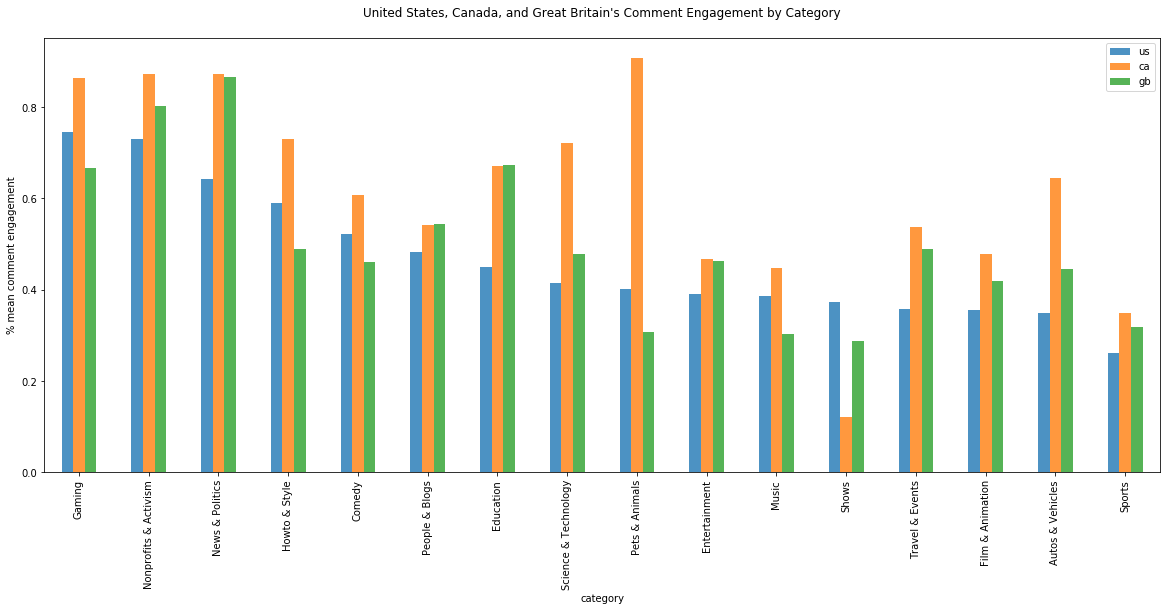

In [38]:
plot_comm_eng()

In [39]:
# Plot comparison of like/dislike engagement by category for the 3 English-speaking countries
def plot_ld_eng():
    all_countries = us_like_dislike_engagement_by_cat;
    all_countries.rename(columns={'like_dislike_engagement': 'us'}, inplace=True)
    all_countries['ca'] = ca_like_dislike_engagement_by_cat['like_dislike_engagement']
    all_countries['gb'] = gb_like_dislike_engagement_by_cat['like_dislike_engagement']
    all_countries.plot.bar(figsize=(20,8), alpha=0.8)    
    plt.title("United States, Canada, and Great Britain's LIke/Dislike Engagement by Category\n")
    plt.ylabel('% mean like_dislike engagement')
    plt.xlabel('category');

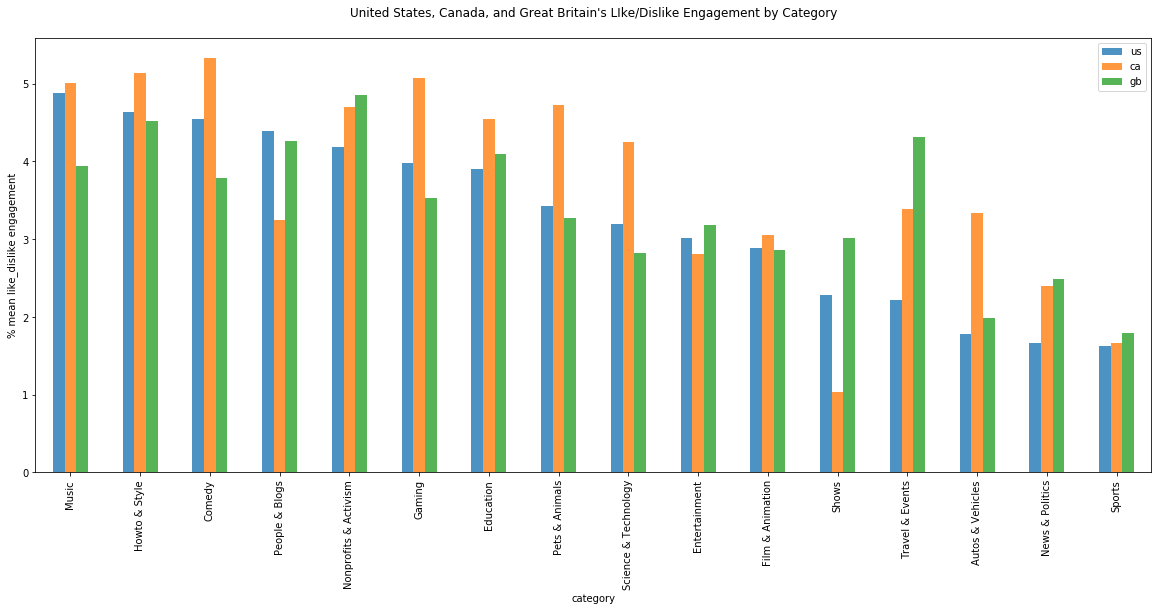

In [40]:
plot_ld_eng()

# Trends over Time

In [41]:
# Create converted_trending_date feature to given df as well as month/year feature
def create_formatted_trending_date(df):
    col = df["trending_date"].apply(lambda x: "20" + x)
    df["trending_date_formatted"] = pd.to_datetime(col, format="%Y.%d.%m")
    trend_date = df["trending_date_formatted"]
    df["trending_month_year"] = pd.to_datetime(trend_date).dt.to_period('M')

In [42]:
create_formatted_trending_date(df_us)
create_formatted_trending_date(df_ca)
create_formatted_trending_date(df_gb)
df_us.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,comment_engagement,like_dislike_engagement,trending_date_formatted,trending_month_year
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,2.13,8.08,2017-11-14,2017-11
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment,0.53,4.27,2017-11-14,2017-11
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy,0.26,4.74,2017-11-14,2017-11
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment,0.63,3.16,2017-11-14,2017-11
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment,0.84,6.40,2017-11-14,2017-11


In [43]:
# Create publish_dates feature from publish_time feature
def create_publish_dates(df):
    df["publish_date"] = df["publish_time"].apply(lambda x: x[:10])
    pd.to_datetime(df["publish_date"], format="%Y-%m-%d")

In [44]:
create_publish_dates(df_us)
create_publish_dates(df_ca)
create_publish_dates(df_gb)
df_ca.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,comment_engagement,like_dislike_engagement,trending_date_formatted,trending_month_year,publish_date
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,...,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,Music,0.73,4.84,2017-11-14,2017-11,2017-11-10
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,...,False,False,False,STill got a lot of packages. Probably will las...,Comedy,1.28,12.76,2017-11-14,2017-11,2017-11-13
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,...,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy,0.26,4.74,2017-11-14,2017-11,2017-11-12
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,...,False,False,False,I know it's been a while since we did this sho...,Entertainment,0.84,6.40,2017-11-14,2017-11,2017-11-12
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,...,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...,Music,0.25,4.94,2017-11-14,2017-11,2017-11-09


## Span month/year

In [45]:
# Generate plot of average views over time for given country
def do_view_trend(df, country_name):
    views_table = df.pivot_table('views', index='trending_month_year', aggfunc='mean')
    views_table.plot(title=country_name + "'s Trending Videos Average Views over Time\n")
    plt.ylabel('average view number')
    plt.xlabel('month/year');

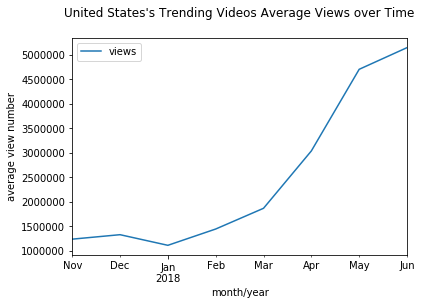

In [46]:
do_view_trend(df_us, "United States")

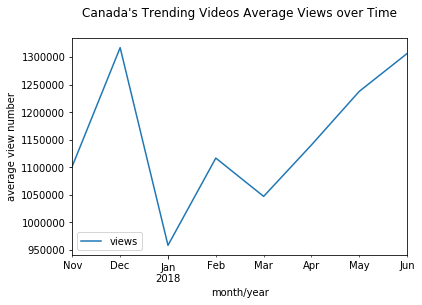

In [47]:
do_view_trend(df_ca, "Canada")

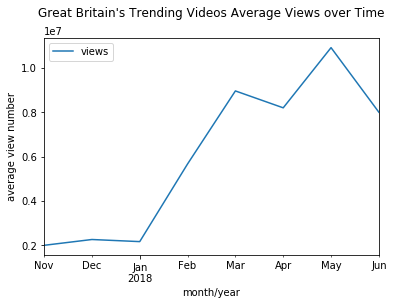

In [48]:
do_view_trend(df_gb, "Great Britain")

In [49]:
# Generate plot of average comment engagement over time for the three English-speaking countries
def compare_comm_engagement():
    comm_gb = df_gb.pivot_table('comment_engagement', index='trending_month_year', aggfunc='mean')
    comm_ca = df_ca.pivot_table('comment_engagement', index='trending_month_year', aggfunc='mean')
    all_comm = df_us.pivot_table('comment_engagement', index='trending_month_year', aggfunc='mean')
    all_comm.rename(columns={'comment_engagement': "United States"}, inplace=True)
    all_comm["Canada"] = comm_ca['comment_engagement']
    all_comm["Great Britain"] = comm_gb['comment_engagement']
    all_comm.plot(title="Unite States, Canada, and Great Britain's Comment Engagement over Time\n")
    all_comm.plot.area(title="Unite States, Canada, and Great Britain's Comment Engagement over Time\n", 
                       alpha=0.5, stacked=False)
    plt.ylabel('average comment engagment')
    plt.xlabel('month/year');

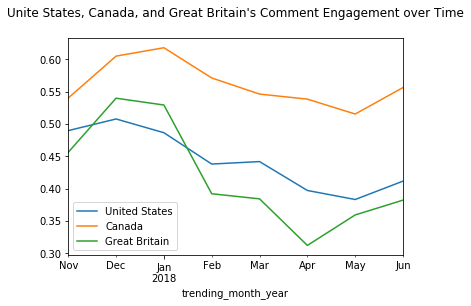

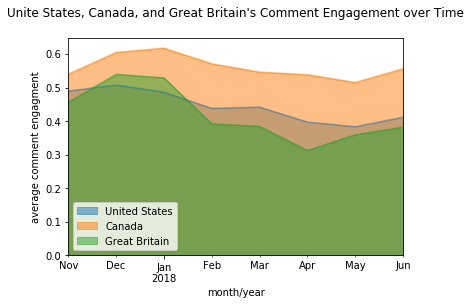

In [50]:
compare_comm_engagement()

In [51]:
# Generate plot of average comment engagement over time for given country
def do_comment_trend(df, country_name):
    comments_table = df.pivot_table('comment_engagement', index='trending_month_year', aggfunc='mean')
    comments_table.plot(title=country_name + "'s Trending Videos Average Comment Engagement over Time")
    comments_table.plot.area(title=country_name + "'s Trending Videos Average Comment Engagement over Time", 
                             alpha=0.6)
    plt.ylabel('% comment engagement')
    plt.xlabel('month/year');

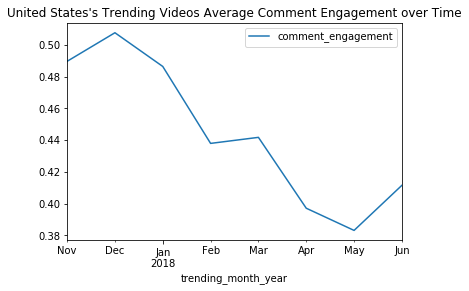

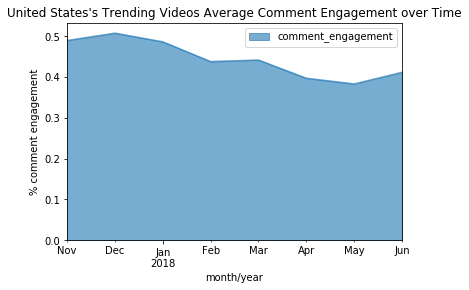

In [52]:
do_comment_trend(df_us, "United States")

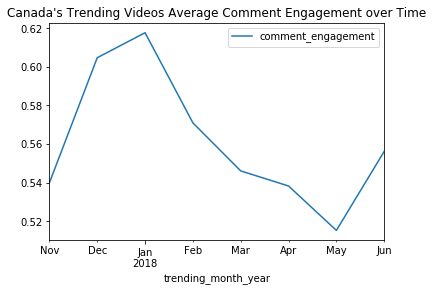

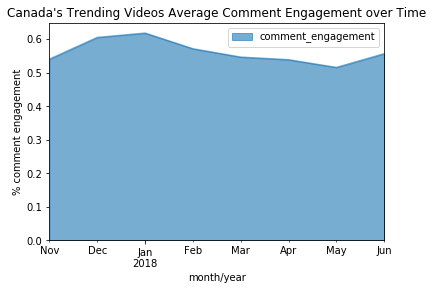

In [53]:
do_comment_trend(df_ca, "Canada")

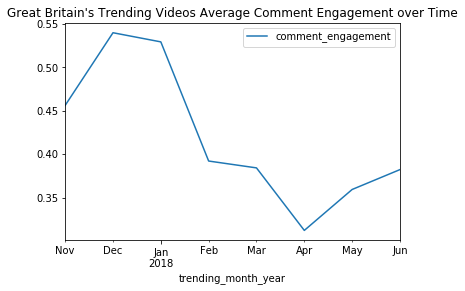

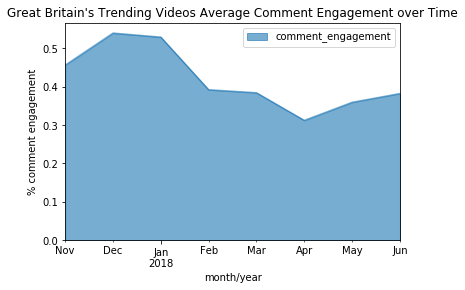

In [54]:
do_comment_trend(df_gb, "Great Britain")

In [55]:
# Generate plot of average like/dislike engagement of the three English-speaking countries
def compare_like_dislike_engagement():
    gb = df_gb.pivot_table('like_dislike_engagement', index='trending_month_year', aggfunc='mean')
    ca = df_ca.pivot_table('like_dislike_engagement', index='trending_month_year', aggfunc='mean')
    all_ld = df_us.pivot_table('like_dislike_engagement', index='trending_month_year', aggfunc='mean')
    all_ld.rename(columns={'like_dislike_engagement': 'United States'}, inplace=True)
    all_ld['Canada'] = ca['like_dislike_engagement']
    all_ld['Great Britain'] = gb['like_dislike_engagement']
    all_ld.plot(title="United States, Canada, and Great Britain's Like/Dislike Engagement over Time\n")
    all_ld.plot.area(title="United States, Canada, and Great Britain's Like/Dislike Engagement over Time\n", 
                     alpha=0.5, stacked=False)
    plt.ylabel('average like_dislike engagment')
    plt.xlabel('month/year');

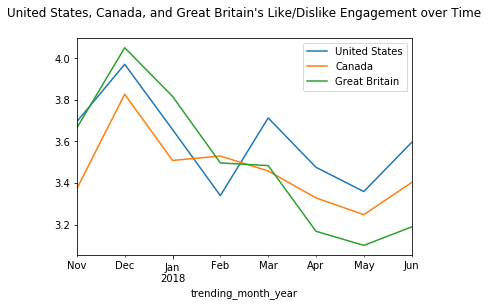

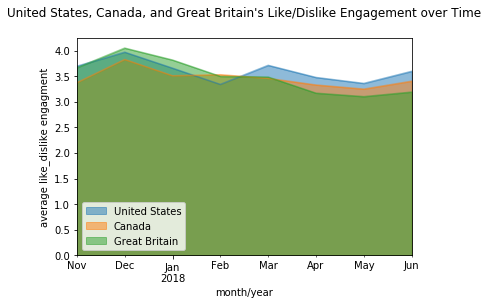

In [56]:
compare_like_dislike_engagement()

In [57]:
# Generate plot of average like/dislike engagement over time for given country
def do_like_dislike_trend(df, country_name):
    like_dislike_table = df.pivot_table('like_dislike_engagement', index='trending_month_year', aggfunc='mean')
    like_dislike_table.plot(title=country_name + "'s Trending Videos Average Like/Dislike Engagement over Time")
    like_dislike_table.plot.area(title=country_name + "'s Trending Videos Average Like/Dislike Engagement over Time",
                                alpha=0.6)
    plt.ylabel('% like/dislike engagement')
    plt.xlabel('month/year');

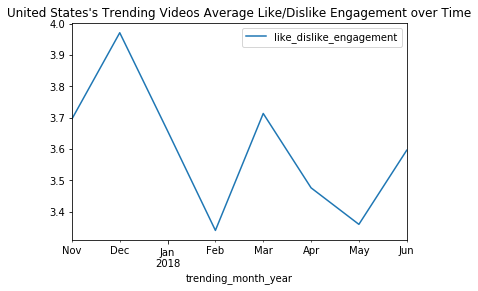

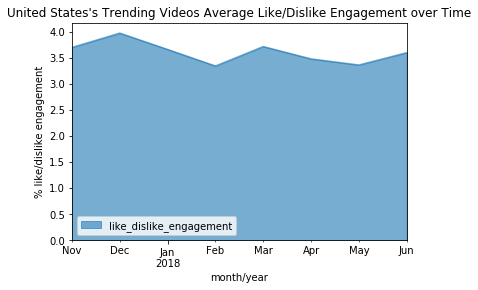

In [58]:
do_like_dislike_trend(df_us, "United States")

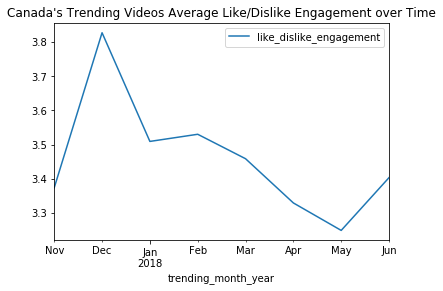

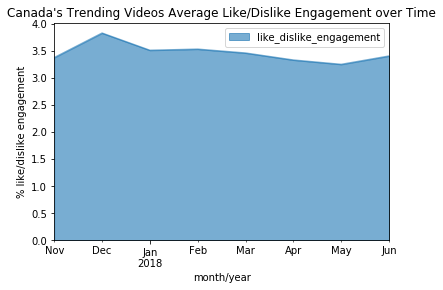

In [59]:
do_like_dislike_trend(df_ca, "Canada")

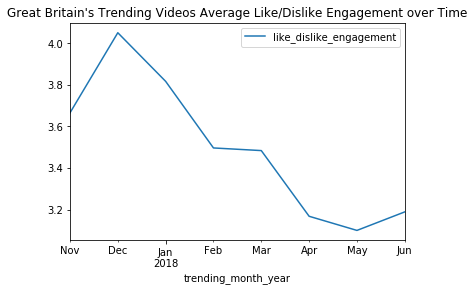

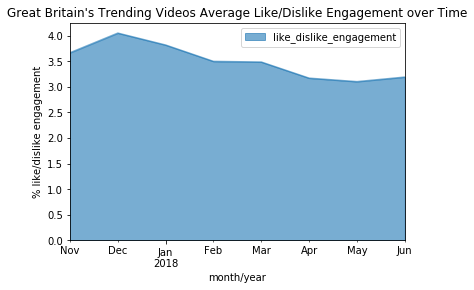

In [60]:
do_like_dislike_trend(df_gb, "Great Britain")

In [61]:
for i in range(len(us_cats)):
    print(df_us.loc[df_us["category_name"] == us_cats["snippet.title"][i], ["trending_month_year", "category_name"]])

      trending_month_year     category_name
8                 2017-11  Film & Animation
29                2017-11  Film & Animation
36                2017-11  Film & Animation
71                2017-11  Film & Animation
86                2017-11  Film & Animation
...                   ...               ...
40868             2018-06  Film & Animation
40886             2018-06  Film & Animation
40893             2018-06  Film & Animation
40937             2018-06  Film & Animation
40947             2018-06  Film & Animation

[2345 rows x 2 columns]
      trending_month_year     category_name
30                2017-11  Autos & Vehicles
58                2017-11  Autos & Vehicles
163               2017-11  Autos & Vehicles
197               2017-11  Autos & Vehicles
265               2017-11  Autos & Vehicles
...                   ...               ...
35240             2018-05  Autos & Vehicles
35450             2018-05  Autos & Vehicles
35654             2018-05  Autos & Vehicles
35857  

In [62]:
# Print viz of each categories' trending pattern over time
def cat_trend(df, country_cats):
    for i in range(len(country_cats)):
        cat_nm = country_cats["snippet.title"][i]
        df_cat_trend_i = df.loc[df["category_name"] == country_cats["snippet.title"][i], ["trending_month_year", "category_name"]]
        table_i = df_cat_trend_i.pivot_table("category_name", index="trending_month_year", aggfunc="count")
        if (len(table_i) == 0):
            continue
        table_i.plot(title = cat_nm + " Trending Pattern over Time")
        plt.ylabel('num of times category trending')
        plt.xlabel('month/year');

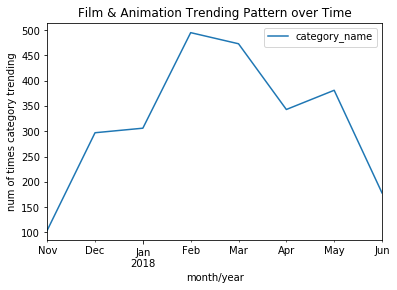

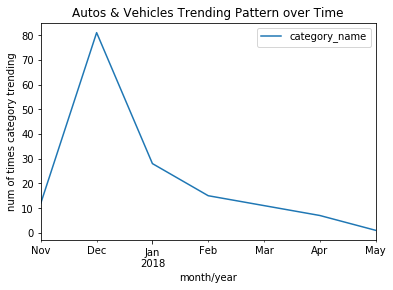

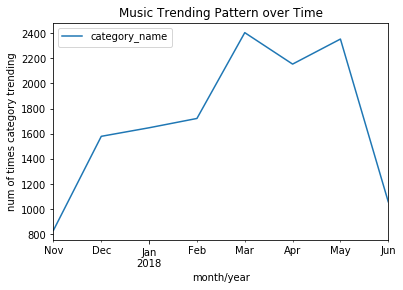

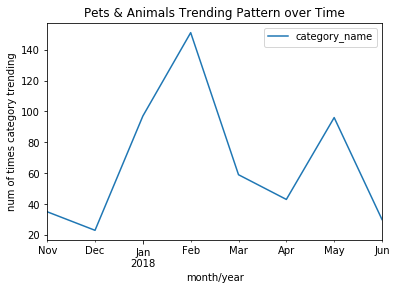

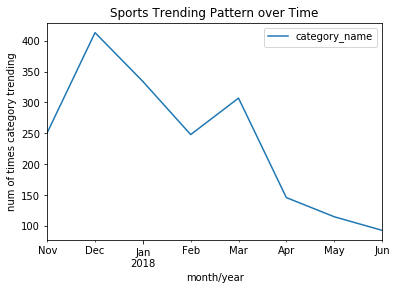

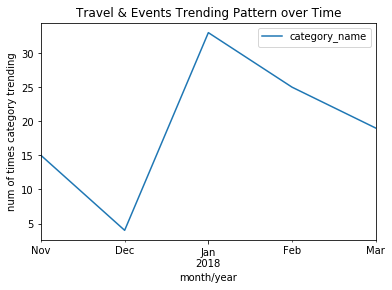

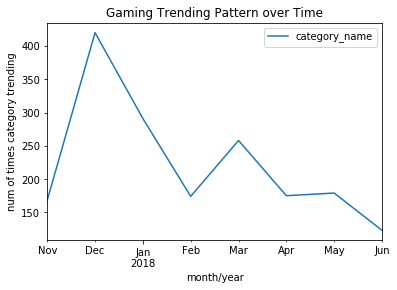

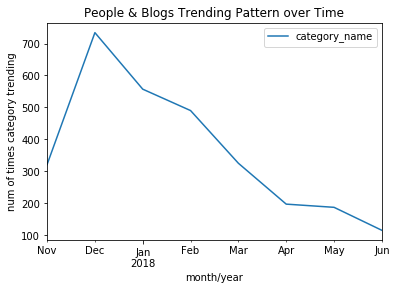

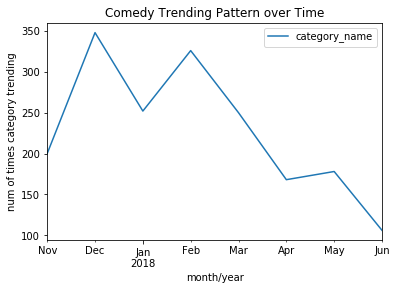

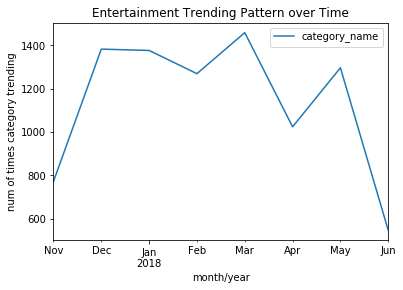

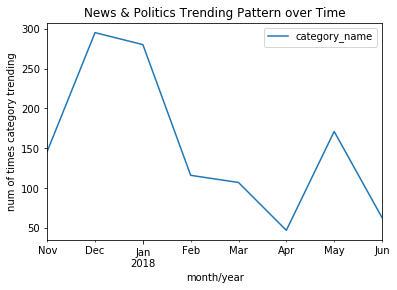

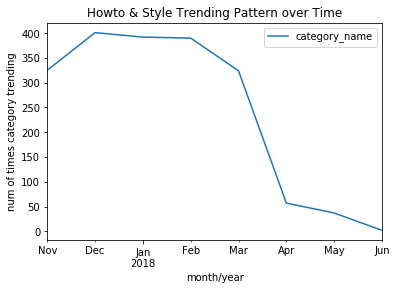

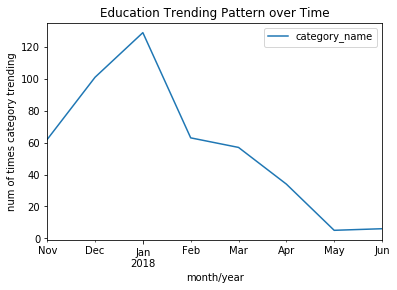

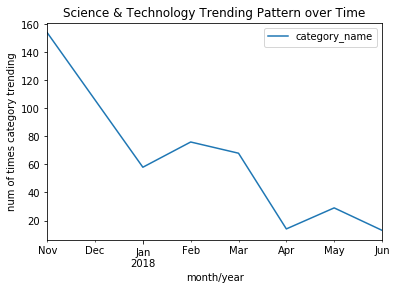

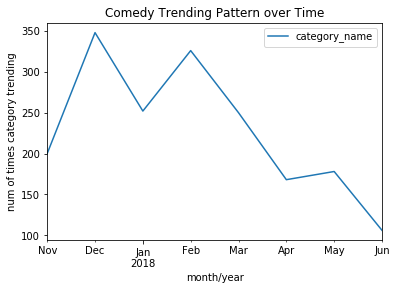

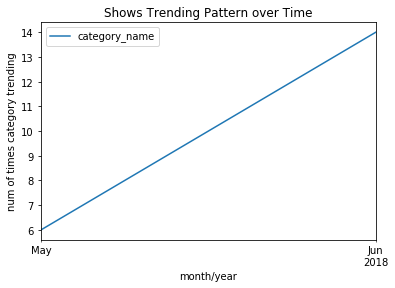

In [63]:
cat_trend(df_gb, gb_cats)

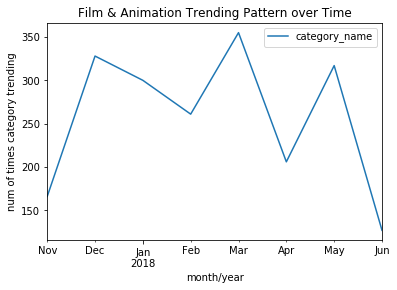

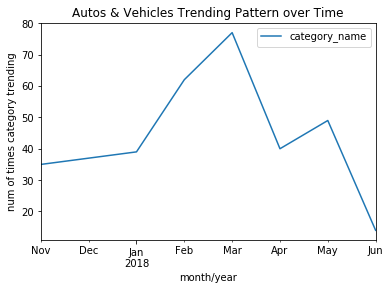

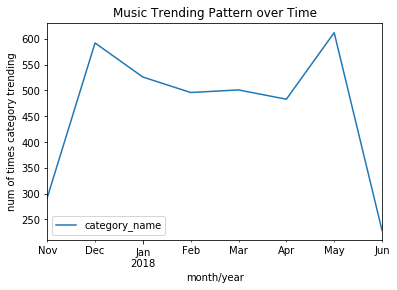

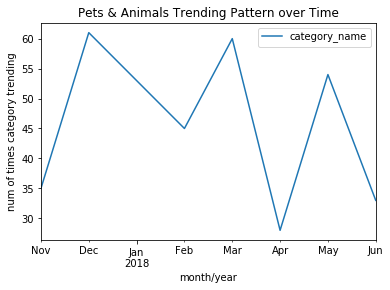

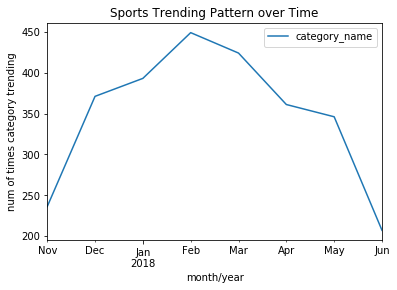

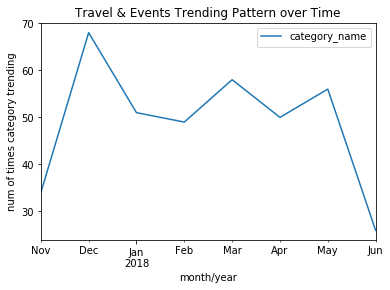

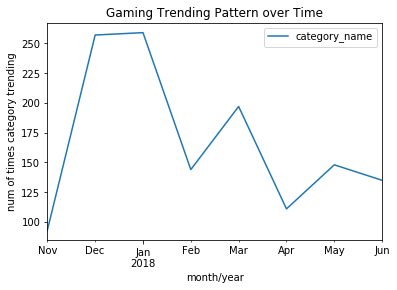

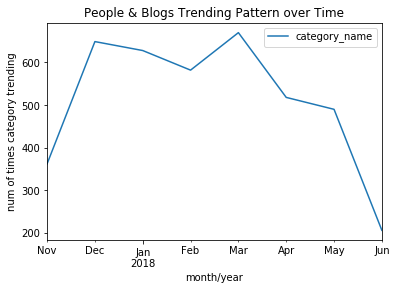

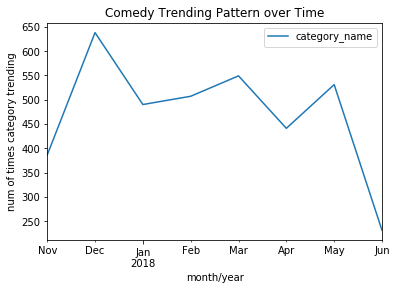

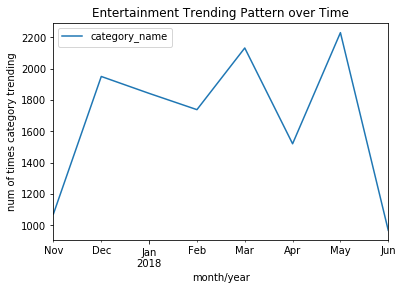

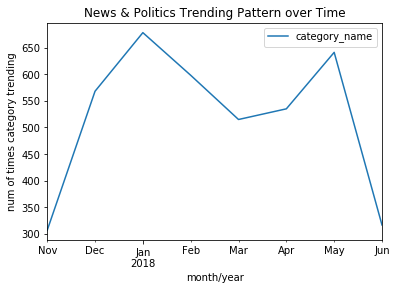

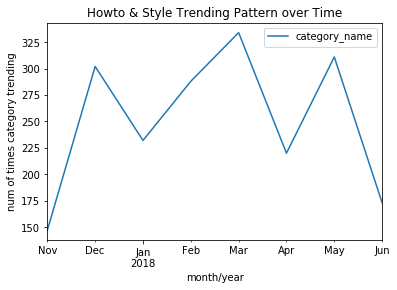

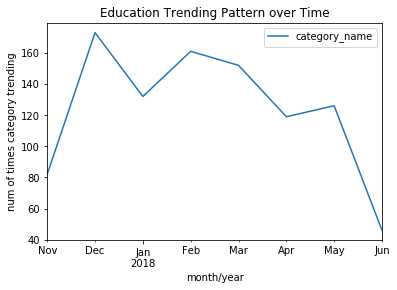

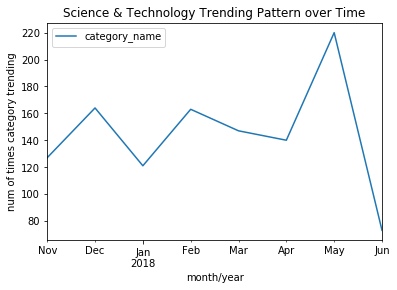

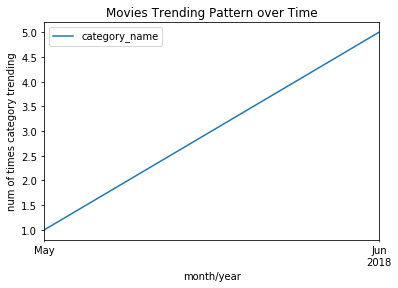

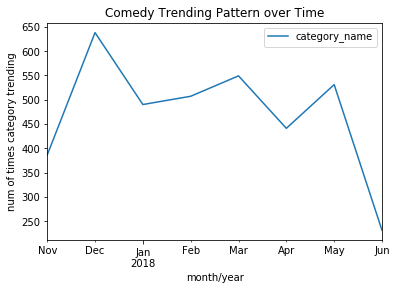

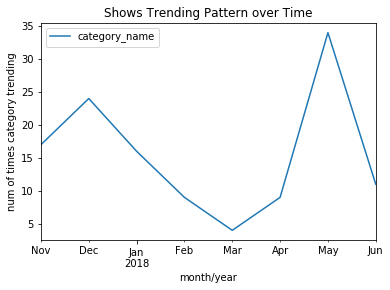

In [64]:
cat_trend(df_ca, ca_cats)

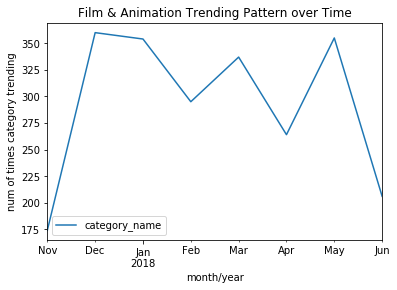

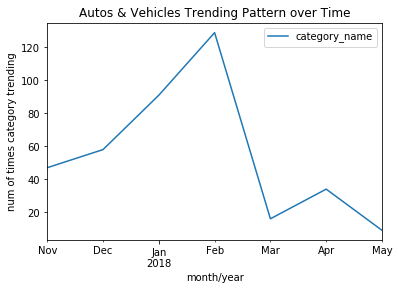

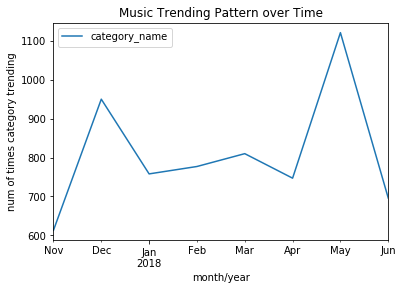

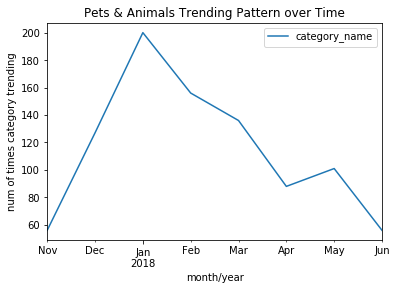

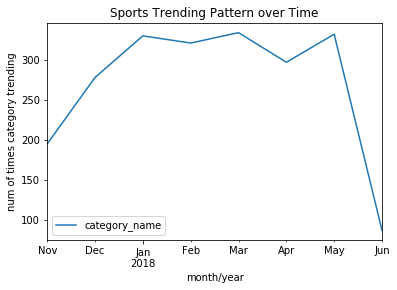

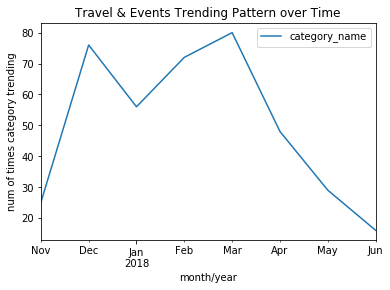

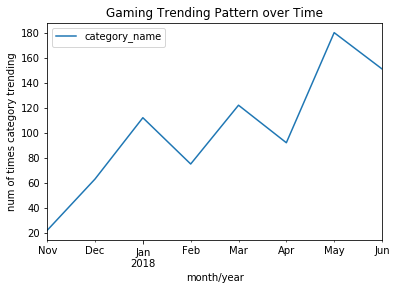

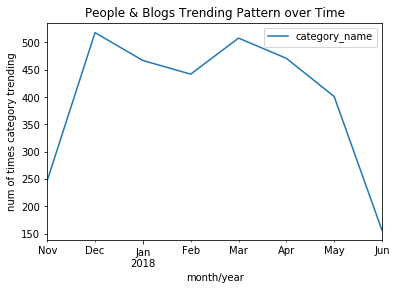

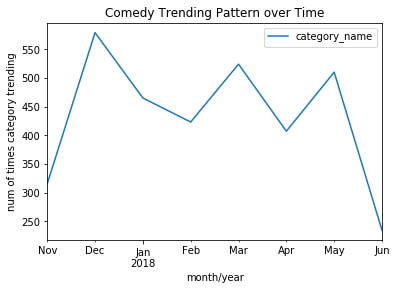

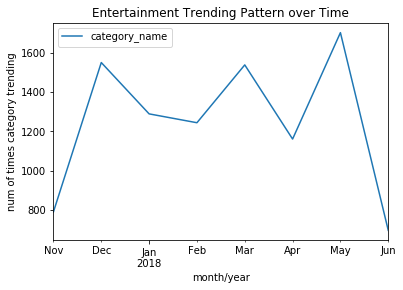

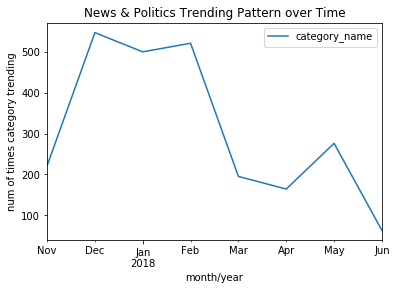

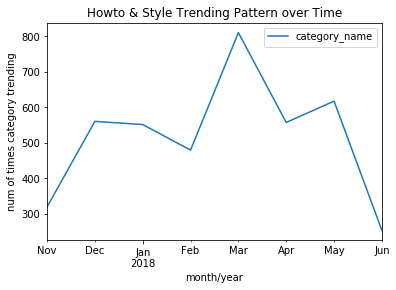

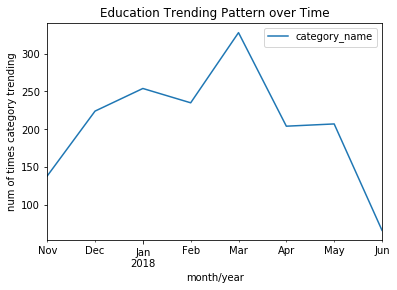

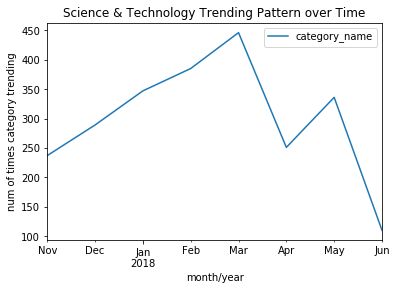

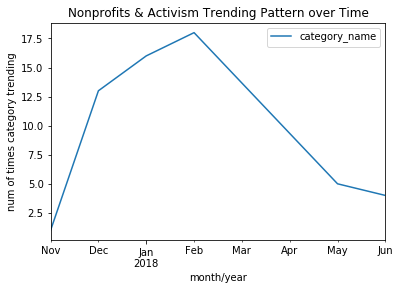

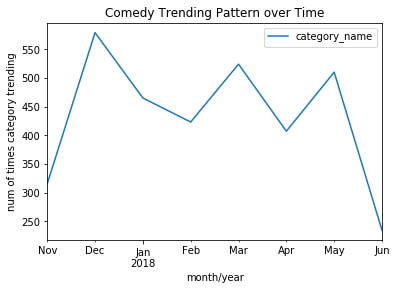

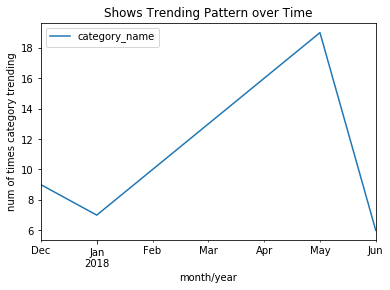

In [65]:
cat_trend(df_us, us_cats)

# Text Association Rules

### Binary CountVectorizer for bag of words

In [66]:
# Create CountVectorizer with binary attribute set to T for only 0/1 values instead of actual counts
cv = CountVectorizer(binary=True, stop_words="english")
vectorized = cv.fit_transform(df_us["title"])
vectorized

<40949x10055 sparse matrix of type '<class 'numpy.int64'>'
	with 235003 stored elements in Compressed Sparse Row format>

In [67]:
# Get dictionary of processed words with counts
words = cv.vocabulary_
print(words)

{'want': 9593, 'talk': 8817, 'marriage': 5580, 'trump': 9237, 'presidency': 6989, 'week': 9663, 'tonight': 9088, 'john': 4751, 'oliver': 6386, 'hbo': 4136, 'racist': 7195, 'superman': 8703, 'rudy': 7676, 'mancuso': 5527, 'king': 4957, 'bach': 822, 'lele': 5198, 'pons': 6890, 'nickelback': 6215, 'lyrics': 5445, 'real': 7290, 'fake': 3255, 'dare': 2364, 'going': 3829, 'bald': 853, 'weeks': 9668, 'iphone': 4590, 'roy': 7663, 'moore': 5979, 'jeff': 4693, 'sessions': 7969, 'cold': 1948, 'open': 6414, 'snl': 8288, 'ice': 4394, 'cream': 2198, 'gadgets': 3652, 'test': 8923, 'greatest': 3910, 'showman': 8098, 'official': 6366, 'trailer': 9148, 'hd': 4137, '20th': 107, 'century': 1657, 'fox': 3551, 'rise': 7549, 'robots': 7584, 'won': 9790, 'mean': 5697, 'end': 3040, 'work': 9808, 'dion': 2623, 'lewis': 5232, '103': 17, 'yd': 9881, 'kick': 4923, 'return': 7477, 'td': 8864, 'vs': 9560, 'denver': 2502, 'miss': 5887, 'play': 6834, 'nfl': 6208, 'wk': 9778, '10': 11, 'highlights': 4216, 'spoilers': 8

In [68]:
# Convert vocabulary dictionary to df
df_words = pd.DataFrame(words.items(), columns=['title_word', 'count'])
df_words

,title_word,count
0,want,9593
1,talk,8817
2,marriage,5580
3,trump,9237
4,presidency,6989
...,...,...
10050,sense,7942
10051,ba,815
10052,smashburgers,8259
10053,katherine,4858


In [69]:
df_vector = pd.DataFrame(vectorized.A, columns=cv.vocabulary_)

In [70]:
df_vector.head()

,want,talk,marriage,trump,presidency,week,tonight,john,oliver,hbo,...,ratatouille,nun,crayola,contract,extension,sense,ba,smashburgers,katherine,langford
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Frequent itemsets

In [205]:
# Itemsets with support of at least 1%
frequent_itemsets = apriori(df_vector, min_support=0.01, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.016264,(superman)
1,0.024469,(electric)
2,0.054922,(founding)
3,0.021295,(earthquakes)
4,0.011282,(fei)


In [206]:
# ** Don't must re-run frequent_itemsets if running this multiple times because it will keep multipling if not
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
frequent_itemsets['support'] = round((frequent_itemsets['support'] * 100), 2) # convert decimal form to percentage
len(frequent_itemsets) # => 45
frequent_itemsets.head()

,support,itemsets,length
23,9.75,(trixie),1
32,6.99,(tati),1
2,5.49,(founding),1
31,4.88,(ingram),1
42,4.76,"(trixie, tati)",2


In [207]:
frequent_one_itemsets = frequent_itemsets[(frequent_itemsets['length'] == 1)]
frequent_one_itemsets.head()

,support,itemsets,length
23,9.75,(trixie),1
32,6.99,(tati),1
2,5.49,(founding),1
31,4.88,(ingram),1
9,3.18,(prompt),1


In [208]:
frequent_two_itemsets = frequent_itemsets[(frequent_itemsets['length'] == 2)]
frequent_two_itemsets.head()

,support,itemsets,length
42,4.76,"(trixie, tati)",2
41,3.37,"(trixie, ingram)",2
37,1.65,"(hosted, ingram)",2
36,1.42,"(trixie, hosted)",2
38,1.36,"(juju, tati)",2


In [209]:
frequent_three_itemsets = frequent_itemsets[(frequent_itemsets['length'] == 3)]
frequent_three_itemsets

,support,itemsets,length
43,1.34,"(trixie, hosted, ingram)",3
44,1.09,"(trixie, rockets, tati)",3


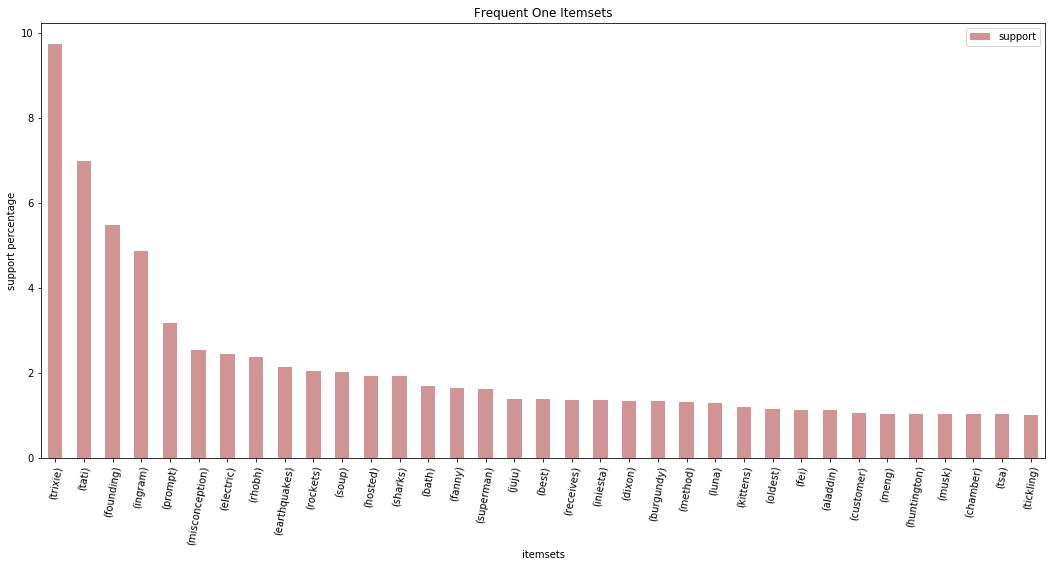

In [210]:
frequent_one_itemsets.plot.bar('itemsets', 'support', color='brown', alpha=0.5, figsize=(18,8))
plt.xticks(rotation=80)
plt.title("Frequent One Itemsets")
plt.ylabel('support percentage')
plt.xlabel('itemsets');

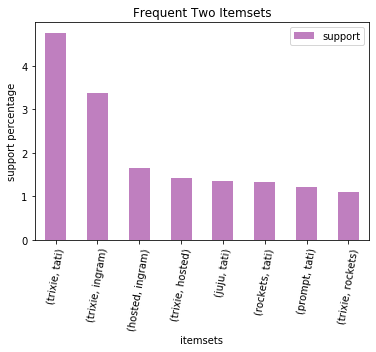

In [193]:
frequent_two_itemsets.plot.bar('itemsets', 'support', color='purple', alpha=0.5)
plt.xticks(rotation=80)
plt.title("Frequent Two Itemsets")
plt.ylabel('support percentage')
plt.xlabel('itemsets');

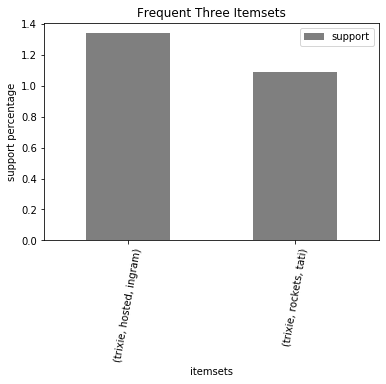

In [197]:
frequent_three_itemsets.plot.bar('itemsets', 'support', color='black', alpha=0.5)
plt.xticks(rotation=80)
plt.title("Frequent Three Itemsets")
plt.ylabel('support percentage')
plt.xlabel('itemsets');

In [213]:
# Generate association rules with a 33% minimum threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.33)
rules['antecedent support'] = rules['antecedent support'] / 100 # convert back to decimal place 
rules['consequent support'] = rules['consequent support'] / 100
rules['support'] = rules['support'] / 100
rules = rules.sort_values(by='confidence', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,"(trixie, rockets)",(tati),0.0109,0.0699,0.0109,1.000000,0.143062,-6.5291,inf
7,(juju),(tati),0.0139,0.0699,0.0136,0.978417,0.139974,-8.3561,-277.536667
8,"(trixie, hosted)",(ingram),0.0142,0.0488,0.0134,0.943662,0.193373,-5.5896,-68.870000
4,(hosted),(ingram),0.0194,0.0488,0.0165,0.850515,0.174286,-7.8172,-25.955862
16,"(rockets, tati)",(trixie),0.0133,0.0975,0.0109,0.819549,0.084056,-11.8775,-48.489583
10,"(hosted, ingram)",(trixie),0.0165,0.0975,0.0134,0.812121,0.083294,-14.7475,-46.572581
6,(hosted),(trixie),0.0194,0.0975,0.0142,0.731959,0.075073,-17.4950,-32.644231
11,(hosted),"(trixie, ingram)",0.0194,0.0337,0.0134,0.690722,0.204962,-5.1978,-7.663000
3,(ingram),(trixie),0.0488,0.0975,0.0337,0.690574,0.070828,-44.2100,-28.278146
1,(tati),(trixie),0.0699,0.0975,0.0476,0.680973,0.069843,-63.3925,-27.427130


In [245]:
# Determing if user's proposed title contains US trending video frequent itemsets
def is_good_title(title):
    token_title = word_tokenize(title)
    li_itemsets = [str(x)[12:-3] for x in frequent_itemsets['itemsets']]
    matches_supp = set(token_title) & set(li_itemsets)
    matches_supp_len = len(matches_supp)
    matches_supp_str = ', '.join(matches_supp)
    return ("Proposed title contains " + str(matches_supp_len) + " high support matche(s): "
           + matches_supp_str)

In [247]:
is_good_title("bay shark is the not the best and needs a bath")

'Proposed title contains 2 high support matche(s): best, bath'